## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as scl

# modify to where you store your project data including utils.py
datadir = "/content/drive/MyDrive/Fall2022 MCS/CS445/Project3/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [6]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    
    im_h, im_w = img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    # test to check if everything is printing fine
    # print(im2var)


    '''
    Objective 1: To minimimize gradient costs.
    We will utilize both objectives with all pixels. Since each objective will
    give one euqation, each pixel will have two corresponding equations, and
    the size of the matrix A will be (2 * img_h * img_w, img_w * img_h). 
    '''
    A = scipy.sparse.lil_matrix((2 * im_h * im_w, im_h * im_w), dtype='double') # init lil
    b = np.zeros((2 * im_h * im_w, 1), dtype = 'double')
    # print(f'initial array: {A}')

    e = 0                                                     
    for x in range(im_h):                                                                   
        for y in range(im_w):                                                               
            if (x == 0 and y == 0):
                A[e, im2var[x][y]] = 1
                b[e] = img[x][y]
            # if the pixel is in the first row
            elif x == 0: 
                e = e + 1
                A[e, im2var[x][y]] = 1
                A[e, im2var[x][y-1]] = -1
                b[e] = img[x][y] - img[x][y-1]
            # if the pixel is in the first column
            elif y == 0:
                e = e + 1
                A[e, im2var[x][y]] = 1
                A[e, im2var[x-1][y]] = -1
                b[e] = img[x][y] - img[x-1][y]
            # for all other cases
            else:
                e = e + 1
                A[e, im2var[x][y]] = 1
                A[e, im2var[x][y-1]] = -1
                b[e] = img[x][y] - img[x][y-1]

                e = e + 1
                A[e, im2var[x][y]] = 1
                A[e, im2var[x-1][y]] = -1
                b[e] = img[x][y] - img[x-1][y]

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b);
    
    return v[0].reshape(im_h, im_w)



## Part 1 Toy Problem (20 pts)

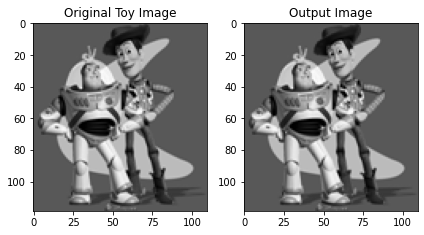

In [8]:
fig, axes = plt.subplots(1, 2)
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
axes[0].imshow(toy_img, cmap='gray')
axes[0].set_title('Original Toy Image')

im_out = toy_reconstruct(toy_img)
axes[1].imshow(im_out,cmap='gray')
axes[1].set_title('Output Image')

fig.tight_layout()


In [9]:
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

Max error is:  8.073677359110576e-06


## Preparation

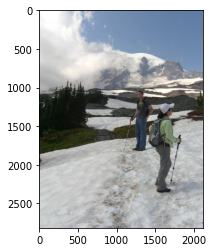

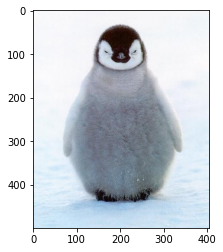

[2066, 352]


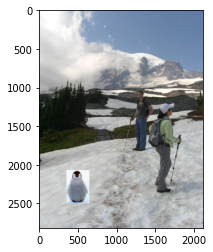

In [ ]:
bg_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(bg_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(bg_img, object_img, object_mask, bg_ul))

  print(bg_ul)



In [ ]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [ ]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [ ]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



NameError: ignored

## Part 2 Poisson Blending (50 pts)

In [10]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """

    start_r = bg_ul[0]
    start_c = bg_ul[1]

    h = object_img.shape[0]
    w = object_img.shape[1]
    
    '''
    # checking if the output has been properly checked
    bg_patch = (bg_img[start_r: start_r + object_img.shape[0], start_c: start_c + object_img.shape[1],1] / 255).copy()
    plt.imshow(bg_patch, cmap='gray')
    plt.show()
    '''
    
    # initialize A, b matrices
    neq = 4 + 3*(w-3) + 3*(h-3) + 2*(h-3)*(w-3)

    A = scipy.sparse.lil_matrix((neq, (h-2) * (w-2)), dtype='double')
    b = np.zeros((neq, 1), dtype = 'double')

    trg_bg_patch = (bg_img[start_r: start_r + object_img.shape[0], start_c: start_c + object_img.shape[1]]).copy()
    trg_bg_patch[1: h-1, 1:w-1] = 0

    # create an im2var matrix
    trg2var = np.arange((h-2) * (w-2)).reshape(h-2, w-2)

    e = 0
# pixels above
    for row in range(1, h-1):                                                                  # 3 4 5
        for col in range(1, w-1):                                                               # 6 7
            if (row == 1):
                A[e, trg2var[row - 1][col - 1]] = 1
                b[e] = (trg_bg_patch[row - 1][col] # background image pixel to the top
                         +  object_img[row][col] - object_img[row - 1][col])
                e = e + 1

            else:
                A[e, trg2var[row - 1][col - 1]] = 1
                A[e, trg2var[row - 2][col - 1]] = -1
                b[e] =  object_img[row][col] - object_img[row - 1][col]
                e = e + 1

# pixels to the left
    for row in range(1, h-1):                                                                  # 3 4 5
        for col in range(1, w-1):                                                               # 6 7
            if (col == 1):
                A[e, trg2var[row - 1][col - 1]] = 1
                b[e] = (trg_bg_patch[row][col - 1] # background image pixel to the left
                         +  object_img[row][col] - object_img[row][col - 1])
                e = e + 1

            else:
                A[e, trg2var[row - 1][col - 1]] = 1
                A[e, trg2var[row - 1][col - 2]] = -1
                b[e] =  object_img[row][col] - object_img[row][col - 1]
                e = e + 1

# for bottom row
    for col in range(1, w-1):
        A[e, trg2var[h - 3][col - 1]] = 1
        b[e] = (trg_bg_patch[h - 1][col] # background image pixel to the bottom
                         +  object_img[h-2][col] - object_img[h-1][col])
        e = e + 1 

# for right column
    for row in range(1, h-1):
        A[e, trg2var[row - 1][w - 3]] = 1
        b[e] = (trg_bg_patch[row][w - 1] # background image pixel to the right
                         +  object_img[row][w-2] - object_img[row][w-1])
        e = e + 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b);
    out_patch =  v[0].reshape((h-2), (w-2))

    return out_patch 



### Poisson Blending - Example 1

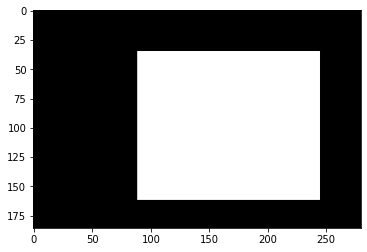

In [25]:
# poisson gradient example 1: mum + dad + panda

bg_img_mixed = cv2.cvtColor(cv2.imread('samples/mum_and_dad.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
obj_img_mixed = cv2.cvtColor(cv2.imread('samples/panda.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (89, 89, 244, 244)
  ys = (35, 161, 161, 35)
  obj_mask_mixed = utils.get_mask(ys, xs, obj_img_mixed)
  bottom_center = (692, 307) # (x,y)

  object_img, object_mask = utils.crop_object_img(obj_img_mixed, obj_mask_mixed)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)


Combining Results

In [26]:
h = object_img.shape[0]
w = object_img.shape[1]

channel_sum = np.zeros((h-2, w-2, 3), dtype = 'double')

for i in range(3):
    channel_sum[:,:,i] += poisson_blend(object_img[:,:,i].copy(), object_mask, bg_img_mixed[:,:,i].copy(), bg_ul)



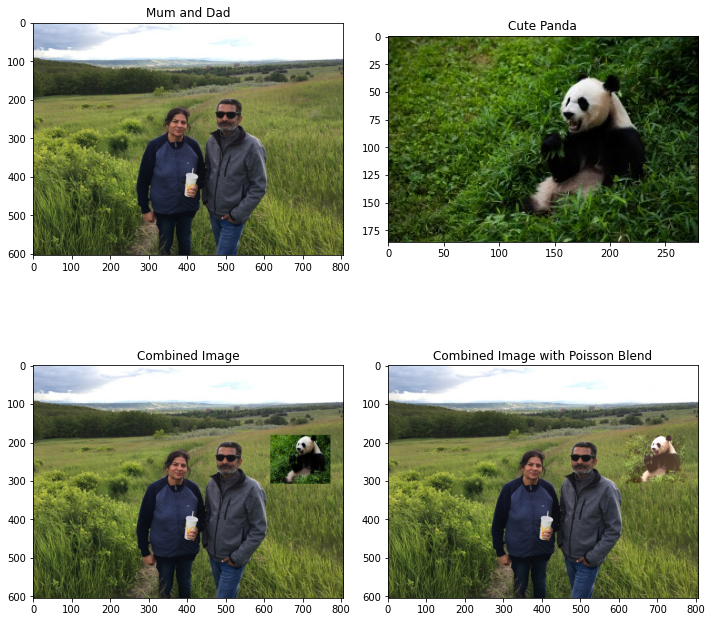

In [27]:
# paste new foreground onto background patch and output 

out_img = bg_img_mixed.copy()
out_img[bg_ul[0] + 1: bg_ul[0] + h - 1, bg_ul[1] + 1: bg_ul[1] + w - 1, :] = channel_sum

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes[0, 0].imshow(bg_img_mixed)
axes[0, 0].set_title('Mum and Dad')
axes[0, 1].imshow(obj_img_mixed)
axes[0, 1].set_title('Cute Panda')
axes[1, 0].imshow(utils.get_combined_img(bg_img_mixed, object_img, object_mask, bg_ul))
axes[1, 0].set_title('Combined Image')
axes[1, 1].imshow(out_img)
axes[1, 1].set_title('Combined Image with Poisson Blend')

fig.tight_layout()


### Poisson Blending - Example 2

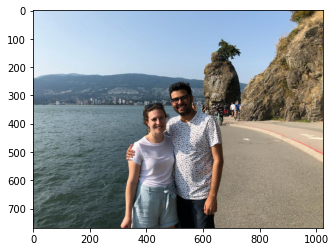

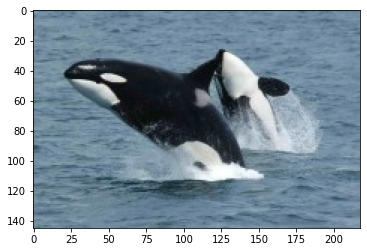

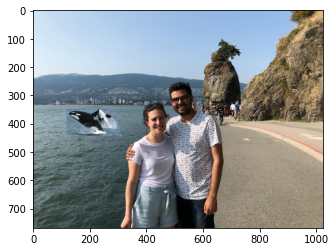

In [31]:
# poisson gradient example 1: mum + dad + panda

bg_img_mixed = cv2.cvtColor(cv2.imread('samples/sid_and_rachel.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(bg_img_mixed)
plt.show()
obj_img_mixed = cv2.cvtColor(cv2.imread('samples/orcas.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(obj_img_mixed)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (11, 12, 207, 180) 
  ys = (24, 117, 121, 15)
  obj_mask_mixed = utils.get_mask(ys, xs, obj_img_mixed)
  bottom_center = (211, 444) # (x,y)

  object_img, object_mask = utils.crop_object_img(obj_img_mixed, obj_mask_mixed)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(bg_img_mixed, object_img, object_mask, bg_ul))

Combining Results

In [32]:
h = object_img.shape[0]
w = object_img.shape[1]

channel_sum = np.zeros((h-2, w-2, 3), dtype = 'double')

for i in range(3):
    channel_sum[:,:,i] += poisson_blend(object_img[:,:,i].copy(), object_mask, bg_img_mixed[:,:,i].copy(), bg_ul)



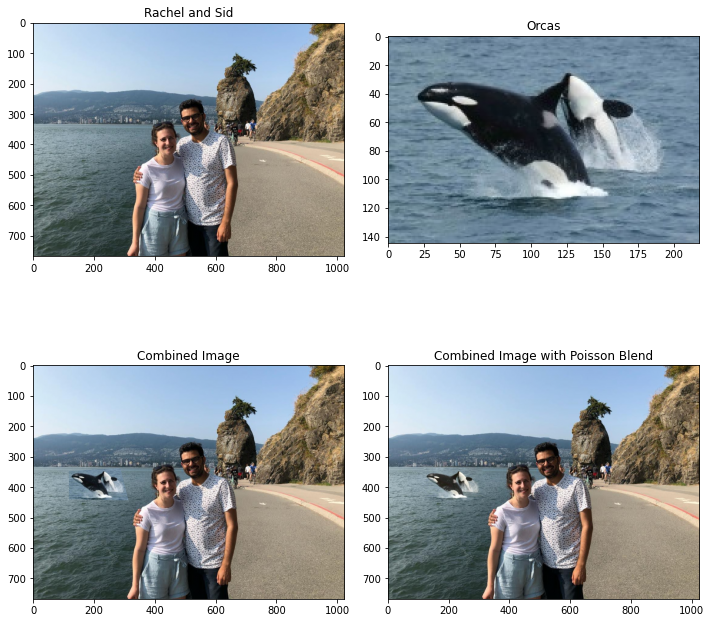

In [34]:
# paste new foreground onto background patch and output 

out_img = bg_img_mixed.copy()
out_img[bg_ul[0] + 1: bg_ul[0] + h - 1, bg_ul[1] + 1: bg_ul[1] + w - 1, :] = channel_sum

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes[0, 0].imshow(bg_img_mixed)
axes[0, 0].set_title('Rachel and Sid')
axes[0, 1].imshow(obj_img_mixed)
axes[0, 1].set_title('Orcas')
axes[1, 0].imshow(utils.get_combined_img(bg_img_mixed, object_img, object_mask, bg_ul))
axes[1, 0].set_title('Combined Image')
axes[1, 1].imshow(out_img)
axes[1, 1].set_title('Combined Image with Poisson Blend')

fig.tight_layout()


### Poisson Blending - Example 3

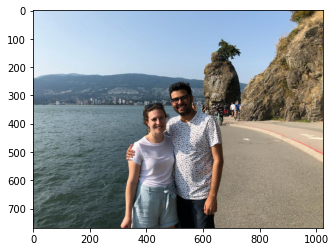

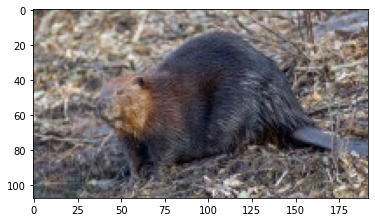

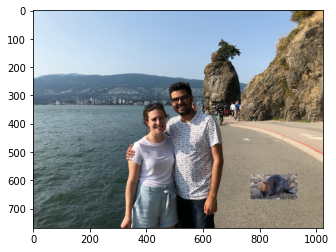

In [47]:
# poisson gradient example 1: mum + dad + panda

bg_img_mixed = cv2.cvtColor(cv2.imread('samples/sid_and_rachel.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(bg_img_mixed)
plt.show()
obj_img_mixed = cv2.cvtColor(cv2.imread('samples/beaver.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(obj_img_mixed)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (13, 179, 182, 15) 
  ys = (14, 10, 102, 100)
  obj_mask_mixed = utils.get_mask(ys, xs, obj_img_mixed)
  bottom_center = (851,668) # (x,y)

  object_img, object_mask = utils.crop_object_img(obj_img_mixed, obj_mask_mixed)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(bg_img_mixed, object_img, object_mask, bg_ul))

Combining Results

In [48]:
h = object_img.shape[0]
w = object_img.shape[1]

channel_sum = np.zeros((h-2, w-2, 3), dtype = 'double')

for i in range(3):
    channel_sum[:,:,i] += poisson_blend(object_img[:,:,i].copy(), object_mask, bg_img_mixed[:,:,i].copy(), bg_ul)



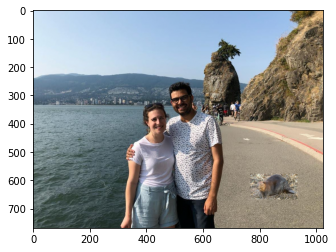

In [49]:
# paste new foreground onto background patch and output 

out_img = bg_img_mixed.copy()
out_img[bg_ul[0] + 1: bg_ul[0] + h - 1, bg_ul[1] + 1: bg_ul[1] + w - 1, :] = channel_sum

plt.figure()
plt.imshow(out_img)
plt.show()


## Part 3 Mixed Gradients (20 pts)

In [39]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """ 

    start_r = bg_ul[0]
    start_c = bg_ul[1]

    h = object_img.shape[0]
    w = object_img.shape[1]
    
    '''
    # checking if the output has been properly checked
    bg_patch = (bg_img[start_r: start_r + object_img.shape[0], start_c: start_c + object_img.shape[1],1] / 255).copy()
    plt.imshow(bg_patch, cmap='gray')
    plt.show()
    '''
    
    # initialize A, b matrices
    neq = 4 + 3*(w-3) + 3*(h-3) + 2*(h-3)*(w-3)

    A = scipy.sparse.lil_matrix((neq, (h-2) * (w-2)), dtype='double')
    b = np.zeros((neq, 1), dtype = 'double')

    bg_patch = (bg_img[start_r: start_r + object_img.shape[0], start_c: start_c + object_img.shape[1]]).copy()

    # create an im2var matrix
    trg2var = np.arange((h-2) * (w-2)).reshape(h-2, w-2)

    e = 0
# pixels above
    for row in range(1, h-1):                                                                  # 3 4 5
        for col in range(1, w-1):                                                               # 6 7
            if (row == 1):
                source_gr = object_img[row][col] - object_img[row - 1][col]
                target_gr = bg_patch[row][col] - bg_patch[row - 1][col]
            
                A[e, trg2var[row - 1][col - 1]] = 1
                if (abs(source_gr) > abs(target_gr)):
                    b[e] = source_gr + bg_patch[row - 1][col]
                else:
                    b[e] = target_gr + bg_patch[row - 1][col]
                e = e + 1

            else:
                A[e, trg2var[row - 1][col - 1]] = 1
                A[e, trg2var[row - 2][col - 1]] = -1
                
                if (abs(source_gr) > abs(target_gr)):
                    b[e] = source_gr
                else:
                    b[e] = target_gr
                e = e + 1

# pixels to the left
    for row in range(1, h-1):                                                                  # 3 4 5
        for col in range(1, w-1):                                                               # 6 7
            source_gr = object_img[row][col] - object_img[row][col - 1]
            target_gr = bg_patch[row][col] - bg_patch[row][col - 1]
            
            if (col == 1):
                A[e, trg2var[row - 1][col - 1]] = 1
                if (abs(source_gr) > abs(target_gr)):
                    b[e] = source_gr + bg_patch[row][col - 1]
                else:
                    b[e] = target_gr + bg_patch[row][col - 1]
                e = e + 1

            else:
                A[e, trg2var[row - 1][col - 1]] = 1
                A[e, trg2var[row - 1][col - 2]] = -1
                if (abs(source_gr) > abs(target_gr)):
                    b[e] = source_gr
                else:
                    b[e] = target_gr
                e = e + 1

# for bottom row
    for col in range(1, w-1):
        source_gr = object_img[h-2][col] - object_img[h-1][col]
        target_gr = bg_patch[h-2][col] - bg_patch[h-1][col]
        
        A[e, trg2var[h - 3][col - 1]] = 1
        if (abs(source_gr) > abs(target_gr)):
            b[e] = source_gr + bg_patch[h-1][col]
        else:
            b[e] = target_gr + bg_patch[h-1][col]
        e = e + 1 

# for right column
    for row in range(1, h-1):
        source_gr = object_img[row][w-2] - object_img[row][w-1]
        target_gr = bg_patch[row][w-2] - bg_patch[row][w-1]
        
        A[e, trg2var[row - 1][w - 3]] = 1
        if (abs(source_gr) > abs(target_gr)):
            b[e] = source_gr + bg_patch[row][w-1]
        else:
            b[e] = target_gr + bg_patch[row][w-1]
        e = e + 1      

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b);
    out_patch =  v[0].reshape((h-2), (w-2))

    # trg_bg_patch[1:h-1, 1:w-1] = out_patch
    
    # out_img = bg_img.copy()
    # out_img[bg_ul[0]: bg_ul[0] + h, bg_ul[1]: bg_ul[1] + w] = trg_bg_patch.copy()

    return out_patch
  

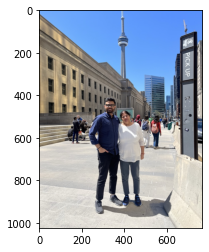

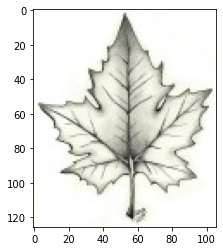

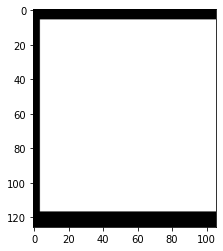

In [41]:
# mixed gradient example 

bg_img_mixed = cv2.cvtColor(cv2.imread('samples/sid_and_mum.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(bg_img_mixed)
plt.show()
obj_img_mixed = cv2.cvtColor(cv2.imread('samples/maple_leaf.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(obj_img_mixed)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (4, 4, 105, 105)
  ys = (6, 116, 116, 6)
  obj_mask_mixed = utils.get_mask(ys, xs, obj_img_mixed)
  bottom_center = (506, 133) # (x,y)

  object_img, object_mask = utils.crop_object_img(obj_img_mixed, obj_mask_mixed)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)

In [ ]:
object_img.shape

(67, 275, 3)

In [42]:
h = object_img.shape[0]
w = object_img.shape[1]

channel_sum = np.zeros((h-2, w-2, 3), dtype = 'double')

for i in range(3):
    channel_sum[:,:,i] += mixed_blend(object_img[:,:,i].copy(), object_mask, bg_img_mixed[:,:,i].copy(), bg_ul)

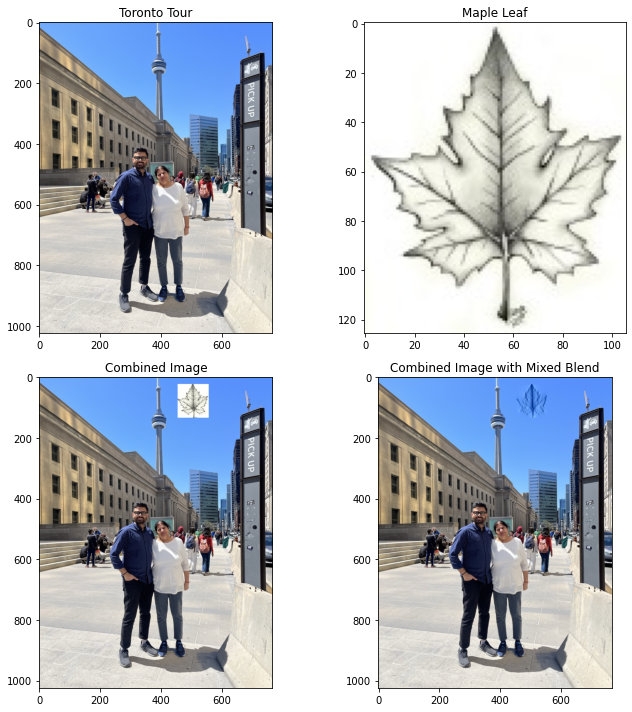

In [43]:
# paste new foreground onto background patch and output 

out_img = bg_img_mixed.copy()
out_img[bg_ul[0] + 1: bg_ul[0] + h - 1, bg_ul[1] + 1: bg_ul[1] + w - 1, :] = channel_sum

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes[0, 0].imshow(bg_img_mixed)
axes[0, 0].set_title('Toronto Tour')
axes[0, 1].imshow(obj_img_mixed)
axes[0, 1].set_title('Maple Leaf')
axes[1, 0].imshow(utils.get_combined_img(bg_img_mixed, object_img, object_mask, bg_ul))
axes[1, 0].set_title('Combined Image')
axes[1, 1].imshow(out_img)
axes[1, 1].set_title('Combined Image with Mixed Blend')

fig.tight_layout()

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)